## Regressão simbólica aplicada ao modelo populacional de Malthuls 

<p style='text-align: justify'> Nesse Notebook, estamos trabalhando a aplicação da regressão simbólica no modelo populacional de Malthus, o qual buscamos fazer uma otimização para aproximar soluções de expressões matemáticas de equações diferenciais. Usamos, para isso, a construção de um algoritmo genético evolutivo. </p>

<p style='text-align: justify'> Para iniciar o nosso processo de regressão, precisamos importar o módulo DEAP do Python, onde temos armanezadas todas as funções e operadores necessários para criar o algoritmo. Além disso, importamos as bibliotecas numpy, sympy, operator. </p>

## Importações

In [1]:
from deap import base, creator, tools, gp
from deap.algorithms import eaSimple
import math
import numpy
import operator
import random as rd
import numpy as np
import sympy as sp
import matplotlib.pyplot as plt
plt.style.use('seaborn-bright')
from sympy import Symbol, expand
from funcoes import malthus, runge_kutta
from funcoes import Div, Exp

### Solução numérica para o modelo dada pelo método de Runge-Kutta

<p style='text-align: justify'> Defnindo os valores de constantes para aplicar o método de Runge-Kutta. Utilizamos esse método uma vez que queremos comparar o indivíduo gerado pela regressão com a solução numérica definida pelo método de aproximação de Runge-Kutta, o qual é ótimo para aproximar funções diferenciais. Essa abordagem foi escolhida para uma generalização onde não conhecemos a solução real da EDO, tratando a aproximação por Runge-Kutta como a solução analítica. Importante ressaltar que os valores de 'X0' e 'K' aqui expostos foram os parâmetros que retornaram as melhores aproximações. </p>

### Definindo o Problema de Valor Inicial (PVI)

In [2]:
T0 = 0  # Tempo inicial
TF = 1  # Tempo final
H = 0.01  # Passo
X0 = 3  # Valor inicial
K = 1  # Constante da equação diferencial

T, X = runge_kutta(malthus, T0, X0, TF, H, K) # Computando o método de Runge-Kutta

### Definindo os parâmetros do algoritmo genético para regressão simbólica

In [3]:
NUM_GERACOES = 2500 #Número de gerações
TAMANHO_POP = 200 #Tamanho da população
TAMANHO_TORNEIO = 3 #Quantidade de indivíduos que duelam em um mesmo torneio
CHANCE_CRUZAMENTO = 0.50 #Chance de ocorrer cruzamento entre dois indivíduos
CHANCE_MUTACAO = 0.03 #Chance de ocorrer a mutação em um indivíduo 

### Registrando os passos do algoritmo genético

Para montar o nosso algoritmo, usamos a biblioteca deap. Com o objetivo de criar os indivíduos, precisamos ter os genes de antemão. Abaixo, usamos o PrimitiveSet para realizar tal função.
### Algoritmo genético de Regressão simbólica 

Vamos, então, definir as constantes do nosso problema, as quais dizem respeito a quantidade de gerações que queremos otimizar e o tamanho de cada uma.

In [4]:
# Definindo os genes pelo PrimitiveSet
pset = gp.PrimitiveSet("MAIN", 1)
pset.addPrimitive(operator.add, 2)
pset.addPrimitive(operator.sub, 2)
pset.addPrimitive(operator.mul, 2)
pset.addPrimitive(Div, 2)
pset.addPrimitive(operator.neg, 1)
pset.addPrimitive(Exp, 1)

#pset.addPrimitive(np.cos, 1); serve apenas para funções trigonométricas
#pset.addPrimitive(np.sin, 1); serve apenas para funções trigonométricas

# Adicionando uma constante efêmera no PrimitiveSet de genes, importante para garantir que hajam constantes com valores numéricos
pset.addEphemeralConstant("rand105", lambda: rd.randint(-1,1))

# Renomendo o argumento para a expressão ficar em função de 't'
pset.renameArguments(ARG0='t')

<p style='text-align: justify'> Agora podemos criar uma classe para o cálculo do fitness de acordo com os parâmetros exigidos pelo nosso algoritmo, bem como criar uma classe de indivíduo que será criado baseado na sua profundidade máxima do modelo de árvore primitiva do DEAP. </p>

In [5]:
# Convocando a função de fitness e declarando uma minimização
creator.create("FitnessMin", base.Fitness, weights=(-1.0,))

# Convocando a função que cria o indivíduo a partir do PrimitiveSet que representam os genes do indivíduo.
creator.create("Individual", gp.PrimitiveTree, fitness=creator.FitnessMin)  

<p style='text-align: justify'> Além de podermos registrar as ferramentas que serão utilizadas para realizar as operações de algoritmos evolutivos. Ou seja, estamos definindo a forma como os individuos e a população serão gerados de acordo com as funções operadoras do DEAP. </p>

In [6]:
toolbox = base.Toolbox()  # Criando uma caixa de ferramentas
toolbox.register("expr", gp.genHalfAndHalf, pset=pset, min_=1, max_=2)  # Gerando expressões para definir funções e terminais disponíveis
toolbox.register("individual", tools.initIterate, creator.Individual, toolbox.expr)  # Registrando a função de criação do indivíduo
toolbox.register("population", tools.initRepeat, list, toolbox.individual)  # Registrando a função de criação da população
toolbox.register("compile", gp.compile, pset=pset)   # Registrando a função de campilação do indivíduo para torná-lo executável

<p styl='text-align: justify'> Para podermos comparar a regressão e o método de Runge-Kutta, precisamos definir uma função de fitness para calcular o RMSE entre elas. </p>

In [7]:
# Definindo nossa própria função de fitness para gerar o RMSE entre a regressão e a solução numérica (Runge-Kutta)
def fitness(individual, points):
    # solução numérica:
    # Transformar a expressão em função:
    func = toolbox.compile(expr=individual)
    Xexpr = func(T)
    RMSE = np.sqrt(sum((Xexpr - X)**2))
    tamanho = len(str(individual))
    if tamanho > 50:
        return float('inf'),
    else:
        return (RMSE**1) * (1+tamanho/5)**0,

In [8]:
toolbox.register("evaluate", fitness, points = list(np.arange(T0, TF + H, H)))  # Registrando uma função de fitness
toolbox.register("select", tools.selTournament, tournsize=TAMANHO_TORNEIO)   # Registrando o operador de seleção por torneio
toolbox.register("mate", gp.cxOnePoint)   # Registrando o operador de cruzamento
toolbox.register("expr_mut", gp.genFull, min_=0, max_=2)   # Registrando o operador de mutação da árvore para determinar sua profundidade
toolbox.register("mutate", gp.mutUniform, expr=toolbox.expr_mut, pset=pset)  # Registrando o operador de mutação
toolbox.decorate("mate", gp.staticLimit(key=operator.attrgetter("height"), max_value=17))  # Registrando o tamanho limite do indivíduo gerado pelo cruzamento, dado pela quantidade de genes
toolbox.decorate("mutate", gp.staticLimit(key=operator.attrgetter("height"), max_value=17))  # Registrando o tamanho limite do indivíduo gerado pela mutação

<p style='text-align: justify'> Usando as classes Statistic e MultiStatistic do módulo tools do DEAP, para computar estatísticas e múltiplas estatísticas, respectivamente, em uma popoulação. Para isso, usamos uma função lambda que computa o fitness de cada indivíduo para registras as funções do numpy: average, standard deviation e minimum. </p>

In [9]:
stats_fit = tools.Statistics(lambda ind: ind.fitness.values)  # Computando os valores de fitness de indivíduos
stats_size = tools.Statistics(len)  # Computa o comprimento de indivíduos em uma população
mstats = tools.MultiStatistics(fitness=stats_fit, size=stats_size)  # Computa as estatísticas de fitness e tamanho
mstats.register("avg", numpy.mean)   # Registrando a função de média na classe de múltiplas estatísticas
mstats.register("std", numpy.std)   # Registrando a função de desvio padrão na classe
mstats.register("min", numpy.min)   # Registrando a função de mínimo valor na classe

<p style='text-align: justify'> A seguir, trabalhamos o processo de criação de uma população de indivíduos que possui um tamanho definido anteriormente, os quais são selecionados os melhores pelo Hall da Fama, dado por uma função de registro dos melhores indivíduos encontrados. Isso é feito pela função eaSimple do DEAP, que evolui uma população aplicando os operadores genéticos para criar e selecionar os melhores indivíduos. 
Essa função recebe os seguintes argumentos:

<ul>
    <li>população</li>
    <li>a caixa de ferramentas</li>
    <li>as chances de mutação e cruzamento</li>
    <li>o número de gerações</li>
    <li>as estatísticas computadas</li>
    <li>o Hall da Fama</li>
    <li>e um comando de print para dar continuidade no loop</li>
</ul>
    
</p>

In [10]:
pop = toolbox.population(n=TAMANHO_POP)    # Cria uma população de tamanho "TAMAHO_POP"
hof = tools.HallOfFame(5)    # Cria um Hall da Fama para armazenar os melhores 5 indivíduos
pop, log = eaSimple(pop, toolbox,
                cxpb=CHANCE_CRUZAMENTO,mutpb=CHANCE_MUTACAO, 
                ngen=NUM_GERACOES , stats=mstats, halloffame=hof, verbose=True)   # Realizando a evolução da população

   	      	                fitness                	                  size                 
   	      	---------------------------------------	---------------------------------------
gen	nevals	avg    	gen	min    	nevals	std    	avg 	gen	min	nevals	std    
0  	200   	54.1047	0  	5.06825	200   	21.5345	3.79	0  	2  	200   	1.69585
1  	127   	44.3033	1  	5.06825	127   	13.8676	3.635	1  	2  	127   	1.68576
2  	94    	36.3603	2  	5.06825	94    	9.38858	3.59 	2  	1  	94    	1.63765
3  	128   	34.1423	3  	5.06825	128   	15.1862	3.79 	3  	1  	128   	1.73951
4  	102   	26.9174	4  	5.06825	102   	14.732 	4.15 	4  	1  	102   	1.72554
5  	103   	24.8227	5  	5.06825	103   	23.7923	4.53 	5  	1  	103   	1.8053 
6  	88    	21.6647	6  	5.06825	88    	33.5737	4.65 	6  	2  	88    	1.66958
7  	130   	28.1774	7  	5.06825	130   	39.337 	4.57 	7  	1  	130   	1.6897 
8  	108   	23.2091	8  	5.06825	108   	27.2977	4.565	8  	2  	108   	1.71633
9  	100   	22.25  	9  	5.06825	100   	33.4947	4.485	9  	2  	100   	1.4

c:\venv\ilumpy\lib\site-packages\numpy\core\_methods.py:236: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


21 	112   	1.34406e+41	21 	5.06825	112   	1.89603e+42	5.03 	21 	2  	112   	2.17005
22 	88    	78.3398    	22 	5.06825	88    	806.726    	5.185	22 	2  	88    	2.09542
23 	99    	115.796    	23 	5.06825	99    	959.714    	5.305	23 	2  	99    	2.20045
24 	132   	inf        	24 	5.06825	132   	nan        	5.02 	24 	2  	132   	2.31292
25 	113   	inf        	25 	5.06825	113   	nan        	5.1  	25 	2  	113   	2.35584
26 	120   	134.85     	26 	5.06825	120   	979.282    	5.13 	26 	1  	120   	2.33947
27 	107   	inf        	27 	5.06825	107   	nan        	5.36 	27 	1  	107   	2.30443
28 	101   	inf        	28 	5.06825	101   	nan        	5.615	28 	2  	101   	2.61854
29 	120   	inf        	29 	5.06825	120   	nan        	5.735	29 	2  	120   	2.73034
30 	104   	inf        	30 	5.06825	104   	nan        	5.615	30 	2  	104   	2.45291


C:\Users\HEITOR~1\AppData\Local\Temp/ipykernel_31856/3511287051.py:7: RuntimeWarning: overflow encountered in square
  RMSE = np.sqrt(sum((Xexpr - X)**2))


31 	117   	inf        	31 	5.06825	117   	nan        	5.735	31 	2  	117   	2.85391
32 	91    	inf        	32 	5.06825	91    	nan        	5.86 	32 	2  	91    	2.81787
33 	107   	inf        	33 	5.06825	107   	nan        	6.06 	33 	2  	107   	2.85244
34 	101   	inf        	34 	5.06825	101   	nan        	6.235	34 	2  	101   	3.01658
35 	115   	inf        	35 	5.06825	115   	nan        	6.245	35 	1  	115   	2.90774
36 	86    	inf        	36 	5.06825	86    	nan        	6.585	36 	2  	86    	2.95343
37 	104   	inf        	37 	5.06825	104   	nan        	6.61 	37 	2  	104   	3.08187
38 	114   	inf        	38 	5.06825	114   	nan        	6.57 	38 	1  	114   	3.34591
39 	101   	inf        	39 	5.06825	101   	nan        	6.535	39 	2  	101   	3.0346 
40 	92    	inf        	40 	5.06825	92    	nan        	6.43 	40 	2  	92    	2.92149
41 	112   	inf        	41 	5.06825	112   	nan        	6.54 	41 	1  	112   	2.94591
42 	106   	inf        	42 	5.06825	106   	nan        	6.67 	42 	2  	106   	3.11466


C:\JupyterLab\Ilum2023\Redes\RNAG_Trabalho_Final\Versãp 2\RNAG_Trabalho_Final\funcoes.py:92: RuntimeWarning: overflow encountered in exp
  result = np.exp(x)


43 	104   	inf        	43 	5.06825	104   	nan        	6.77 	43 	2  	104   	3.06547
44 	101   	inf        	44 	5.06825	101   	nan        	6.97 	44 	2  	101   	3.25409
45 	100   	inf        	45 	5.06825	100   	nan        	7.085	45 	2  	100   	2.90994
46 	99    	inf        	46 	5.06825	99    	nan        	7.41 	46 	2  	99    	3.35885
47 	102   	inf        	47 	5.06825	102   	nan        	7.665	47 	1  	102   	3.13732
48 	99    	inf        	48 	5.06825	99    	nan        	7.755	48 	2  	99    	3.39632
49 	104   	inf        	49 	5.06825	104   	nan        	7.625	49 	2  	104   	3.27481
50 	91    	inf        	50 	5.06825	91    	nan        	7.81 	50 	1  	91    	3.38879
51 	92    	inf        	51 	5.06825	92    	nan        	8.39 	51 	2  	92    	3.3879 
52 	95    	inf        	52 	5.06825	95    	nan        	8.405	52 	2  	95    	3.49442
53 	115   	inf        	53 	5.06825	115   	nan        	8.785	53 	2  	115   	3.66589
54 	100   	inf        	54 	5.06825	100   	nan        	8.91 	54 	2  	100   	3.50455
55 	

<p style='text-align: justify'> O valor do RMSE é retornado na sequência de loops gerada acima, podendo ser visto nos dados referentes ao fitness, mais especificamente, na coluna de nome "min", referente a minimização do fitness. </p>

<p styl='text-align: justify'> Assim, finalmente obtendo as expressões retornadas pelo algoritmo, criamos um for loop para printar os indivíduos que foram armazenados no Hall da Fama, em que o primeiro da lista é o melhor indivíduo encontrado. </p>

In [11]:
for i in hof.items:
    print(str(i))
    print()

Exp(add(t, Exp(Exp(sub(sub(-1, 1), Exp(-1))))))

Exp(add(t, Exp(Exp(sub(sub(-1, Exp(-1)), 1)))))

Exp(add(Exp(Exp(sub(sub(-1, Exp(-1)), 1))), t))

Exp(add(t, Exp(Exp(sub(Exp(-1), Exp(1))))))

Exp(add(t, add(1, Exp(sub(sub(-1, Exp(-1)), 1)))))



### Reportando o melhor individuo encontrado

<p style='text-align: justify'> Esse reporte foi feito para obtermos um resultado gráfico para que haja uma comparação clara entre os dois métodos. Portanto, estamos definindo o melhor indivíduo e plotando ele juntamento com a solução por Runge-Kutta. </p>

Exp(add(t, Exp(Exp(sub(sub(-1, 1), Exp(-1))))))


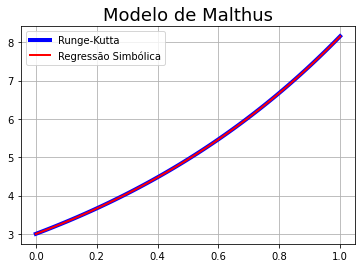

In [12]:
melhor_individuo = str(hof.items[0])
#melhor_individuo_ever = 'X0_mul(Exp(K_mul(t)))'
print(melhor_individuo)
func = toolbox.compile(expr=melhor_individuo)
Xexpr = func(T)
#func = toolbox.compile(expr=melhor_individuo_ever)
#Xbest = func(T)
fig, ax = plt.subplots(1,1)
ax.set_title('Modelo de Malthus', size = 18)
ax.plot(T, X, label = 'Runge-Kutta', c = 'b', linewidth = 4)
ax.plot(T, Xexpr, label = 'Regressão Simbólica', c = 'r', linewidth = 2)
#ax.plot(T, Xbest, label = 'Analitica', c = '0')
ax.legend()

ax.legend()
ax.grid('--')
#plt.savefig('resultados\Resultado_Malthus_1.png', dpi = 200)

<p style='text-align: justify'> Como obtivemos uma representação da expressão como uma string, ou seja, de maneira simbólica, queremos transformá-la em uma representação numérica. Fazemos isso usando o código a seguir. </p>

In [13]:
# Definindo as funções para computar a representação simbólico utilizando o sympy e transformar em funções numéricas
def Div(left, right):
    return left / right

def Exp(x):
    return sp.exp(x)

# Usando um novo PrimitiveSet para definir os operadores matemáticos
new_pset = gp.PrimitiveSet("MAIN", 1)

new_pset.addPrimitive(operator.add, 2)
new_pset.addPrimitive(operator.sub, 2)
new_pset.addPrimitive(operator.mul, 2)
new_pset.addPrimitive(Div, 2)
new_pset.addPrimitive(operator.neg, 1)
new_pset.addPrimitive(sp.cos, 1)
new_pset.addPrimitive(sp.sin, 1)
new_pset.addPrimitive(Exp, 1)

# Novamente adicionando a constante efêmera
new_pset.addEphemeralConstant("rand106", lambda: rd.randint(-1,1))

# Renomeando o argumento para que seja representado em função do tempo
new_pset.renameArguments(ARG0='t')

# Registrando a função de compilação do indivíduo numérico
toolbox.register("compile", gp.compile, pset=new_pset)

In [14]:
func = toolbox.compile(expr=melhor_individuo)  # Compilando o indivíduo em um executável

# Definindo os símbolos como terminais
t = Symbol('t')
X0 = Symbol('X_0')
K = Symbol('k')

<p style='text-align: justify'> Ao final, temos a nossa expressão simbólica que fita os dados </p>

In [15]:
print("O melhor individuo encontrado: ")
display(sp.expand(func(t)))

exp(t)*exp(exp(exp(-2)*exp(-exp(-1))))